<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/062123_SIS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import math as math
from math import log

In [179]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [180]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n)) # max degree allowed is square root of n
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [181]:
def generate_configuration_model(degree_sequence):
    # Create an empty graph and sum up the degrees
    G = nx.Graph()
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")

    # Create a list of nodes based on the degree sequence
    nodes = []
    for node, degree in enumerate(degree_sequence):
        nodes.extend([node] * degree)

    # Shuffle the nodes list
    random.shuffle(nodes)

    # Track visited edges
    existing_edges = set()

    # Pair the nodes and add edges to the graph
    for i in range(0, len(nodes), 2):
        node1 = nodes[i]
        node2 = nodes[i + 1]

        # Check for self-edges and duplicate edges
        if node1 != node2 and (node1, node2) not in existing_edges:
            G.add_edge(node1, node2)
            existing_edges.add((node1, node2))
            existing_edges.add((node2, node1))

    return G

In [182]:
def color_graph_nodes(states, G):
    susceptible_nodes = [node for node, state in states.items() if state == 0]
    infected_nodes = [node for node, state in states.items() if state == 1]
    node_colors = ['green' if node in susceptible_nodes else 'red' for node in G.nodes()]
    nx.draw(G, node_size=15, edge_color="grey", width=1, with_labels=False, node_color=node_colors)
    plt.show()

In [183]:
def OGA_SIS(graph, output, N_sample, mu, lam, max_time, frac_inf):
    N = graph.number_of_nodes()
    degrees = dict(graph.degree())
    kmax = max(degrees.values())

    avg_rho = np.zeros(max_time, np.float64)   # Average for rho at times t, averaged
    avg_t = np.zeros(max_time, np.float64)
    avg_sam = np.zeros(max_time, int)       # number of samples for each time t
    avg_samSurv = np.zeros(max_time, int)   # and of survivng ones

    pos_max = 0
    for sample in range(1, N_sample+1):
        print('Sample Number:', sample)

        print('|| Initial Condition')
        states = {j: 0 for j in graph.nodes()}
        inf = []
        N_inf = 0
        N_e = 0

        # initialize with given fraction of infected individuals
        for node in np.random.permutation(graph.nodes()):
            inf.append(node)
            states[node] = 1
            N_inf += 1
            if len(inf) == int(N * frac_inf):
                break

        t = 0
        pos = 1

        print('|| Run Dynamics')

        while t <= max_time:
            if len(inf) == 0:
                # Choose a node to reinfect if the epidemic disappears
                node = np.random.choice(list(graph.nodes()))
                states[node] = 1    # update the disease status
                inf.append(node)    # add the node to the infected nodes
                N_e -= graph.degree(node)   # update the number of links connecting to infected
                N_inf += 1           # add it to the number of infected

            # total rate
            R = mu * N_inf + lam * N_e
            if R == 0:
                break

            # randomly select time step
            tau = -np.log(np.random.uniform(1e-6, 1)) / R
            # update time
            t += tau

            ## save the data here in the time step before

            # probability of recovery
            p = (mu * N_inf) / R
            # recover if random number less than p
            if np.random.uniform() < p:
                index = np.random.randint(0, N_inf)
                node = inf[index]

                states[node] = 0   # update the disease status
                N_e -= graph.degree(node)   # update the number of links connecting to infected
                N_inf -= 1         # remove it from the number of infected
                inf[index] = inf[N_inf]

            # try to infect otherwise
            else:
                while True:
                    index = np.random.randint(0, N_inf)
                    node = inf[index]
                    if np.random.uniform() < graph.degree(node) / kmax:
                        break

                # infect a neighbor
                node = np.random.choice(list(graph.neighbors(node)))
                # If it is not a phantom process, infect the chosen neighbor
                if states[node] == 0:
                    states[node] = 1    # update the disease status
                    N_e += graph.degree(node)  # update the number of links connecting to infected
                    inf.append(node)  # add the node to the infected nodes
                    N_inf += 1           # add it to the number of infected


                # Save the dynamics by time
                while (t >= pos): # Save data
                    avg_rho[pos - 1] += 1.0*N_inf/N
                    avg_t[pos - 1] += t
                    avg_sam[pos - 1] += 1
                    if N_inf != 0:
                        avg_samSurv[pos - 1] += 1
                        pos_max = max(pos,pos_max) # The maximum t with non-null rho
                    pos += 1

        # Plot the final state of the sample
        # plt.figure()
        # color_graph_nodes(states, graph)

    # Write output file

    with open(output, 'wt') as output_file:
        print(
            '## ***** Algorithm used: Optimized Gillespie Algorithm for SIS (SIS-OGA, NetworkX) *****',
            '#@ Number of nodes: ' + str(N),
            '#@ Number of edges: ' + str(2 * graph.number_of_edges()),
            '#@ Samples: ' + str(N_sample),
            '#! Recovery rate (mu): ' + str(mu),
            '#! Infection rate (lambda): ' + str(lam),
            '#! Maximum time steps: ' + str(max_time),
            '#! Fraction of infected vertices (initial condition): ' + str(frac_inf),
            sep='\n',
            file=output_file)

        for pos in range(0, pos_max):
            print(
                1.0 * avg_t[pos] / avg_sam[pos], 1.0 * avg_rho[pos] / (1.0 * sample),
                file=output_file)

    print('Output file:', output)

In [195]:
def OGA_SIS_2(graph, output, N_sample, mu, lam, max_time, frac_inf):
    N = graph.number_of_nodes()
    degrees = dict(graph.degree())
    kmax = max(degrees.values())

    avg_rho = np.zeros(max_time, np.float64)   # Average for rho at times t, averaged
    avg_t = np.zeros(max_time, np.float64)
    avg_sam = np.zeros(max_time, int)       # number of samples for each time t
    avg_samSurv = np.zeros(max_time, int)   # and of surviving ones

    pos_max = 0
    for sample in range(1, N_sample+1):
        print('Sample Number:', sample)

        states = {j: 0 for j in graph.nodes()}  # Initialize all nodes as susceptible
        inf = []

        # initialize with given fraction of infected individuals
        for node in np.random.permutation(graph.nodes()):
            inf.append(node)
            states[node] = 1
            if len(inf) == int(N * frac_inf):
                break

        t = 0
        pos = 1

        while t <= max_time:
            if len(inf) == 0:
                # Choose a node to reinfect if the epidemic disappears
                node = np.random.choice(list(graph.nodes()))
                states[node] = 1    # update the disease status
                inf.append(node)    # add the node to the infected nodes

            R = mu * len(inf) + lam * sum(graph.degree(node) for node in inf)
            if R == 0:
                break

            tau = -np.log(np.random.uniform(1e-6, 1)) / R
            t += tau

            ## save the data here in the time step before

            p = (mu * len(inf)) / R
            if np.random.uniform() < p:
                index = np.random.randint(0, len(inf))
                node = inf[index]
                states[node] = 0   # update the disease status
                inf.pop(index)

            else:
                while True:
                    index = np.random.randint(0, len(inf))
                    node = inf[index]
                    if np.random.uniform() < graph.degree(node) / kmax:
                        break

                node = np.random.choice(list(graph.neighbors(node)))
                if states[node] == 0:
                    states[node] = 1    # update the disease status
                    inf.append(node)    # add the node to the infected nodes

            while t >= pos: # Save data
                avg_rho[pos - 1] += 1.0 * len(inf) / N
                avg_t[pos - 1] += t
                avg_sam[pos - 1] += 1
                if len(inf) != 0:
                    avg_samSurv[pos - 1] += 1
                    pos_max = max(pos,pos_max) # The maximum t with non-null rho
                pos += 1

        # Plot the final state of the sample
        # plt.figure()
        # color_graph_nodes(states, G)

        # Plot avg_rho/avg_sam against avg_t/avg_sam
        avg_t_avg_sam = avg_t[:pos_max] / avg_sam[:pos_max]
        avg_rho_avg_sam = avg_rho[:pos_max] / sample
        plt.figure()
        plt.plot(avg_t_avg_sam, avg_rho_avg_sam)
        plt.xlabel('Average t / Average samples')
        plt.ylabel('Average rho / Average samples')
        plt.title('Average rho/avg_sam vs. avg_t/avg_sam')

    with open(output, 'wt') as output_file:
        print(
            '## ***** Algorithm used: Optimized Gillespie Algorithm for SIS (SIS-OGA, NetworkX) *****',
            '#@ Number of nodes: ' + str(N),
            '#@ Number of edges: ' + str(2 * graph.number_of_edges()),
            '#@ Samples: ' + str(N_sample),
            '#! Recovery rate (mu): ' + str(mu),
            '#! Infection rate (lambda): ' + str(lam),
            '#! Maximum time steps: ' + str(max_time),
            '#! Fraction of infected vertices (initial condition): ' + str(frac_inf),
            sep='\n',
            file=output_file)

        for pos in range(0, pos_max):
            print(
                1.0 * avg_t[pos] / avg_sam[pos], 1.0 * avg_rho[pos] / (1.0 * sample),
                file=output_file)

    print('Output file:', output)


[4, 5, 3, 3, 5, 4, 3, 3, 5, 3, 3, 3, 3, 7, 3, 5, 3, 5, 3, 3, 4, 5, 4, 4, 3, 4, 12, 3, 3, 3, 3, 3, 5, 5, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 6, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 4, 5, 5, 3, 4, 3, 3, 6, 3, 5, 3, 3, 4, 4, 3, 9, 3, 3, 3, 3, 3, 3, 6, 3, 5, 3, 21, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 5, 4, 4, 4, 6, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

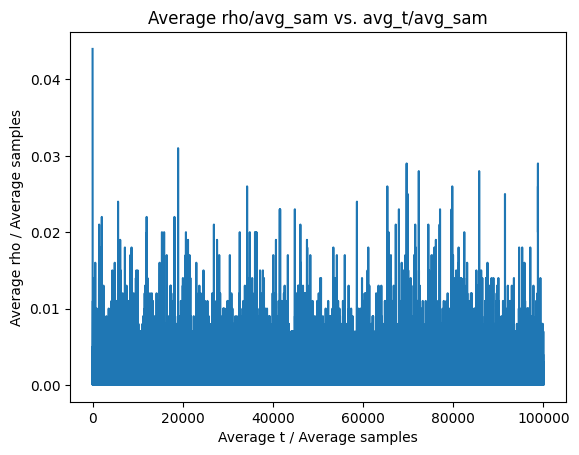

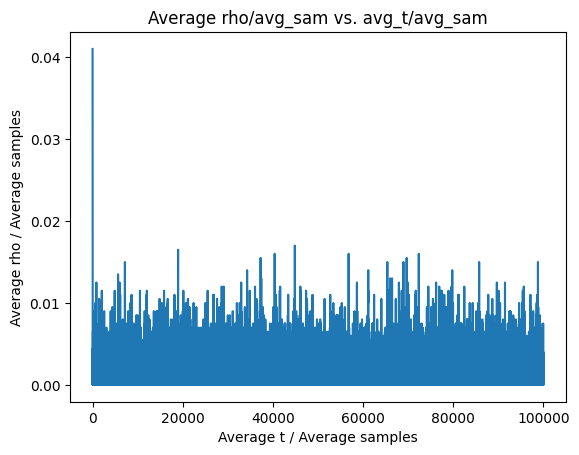

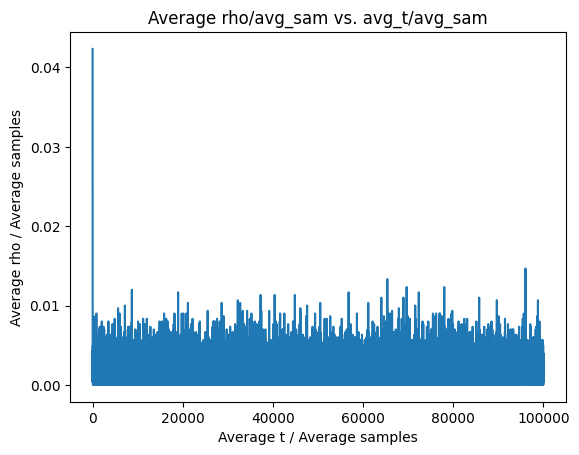

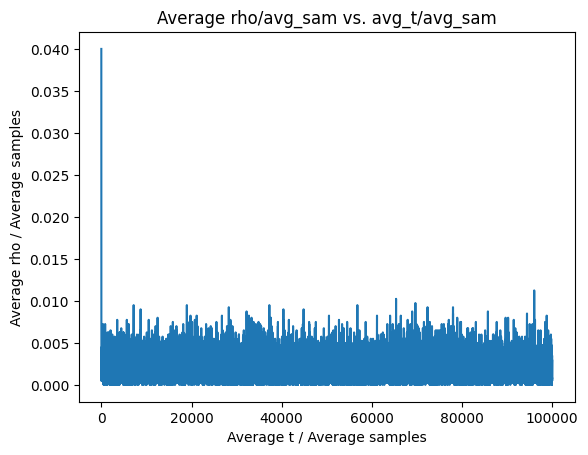

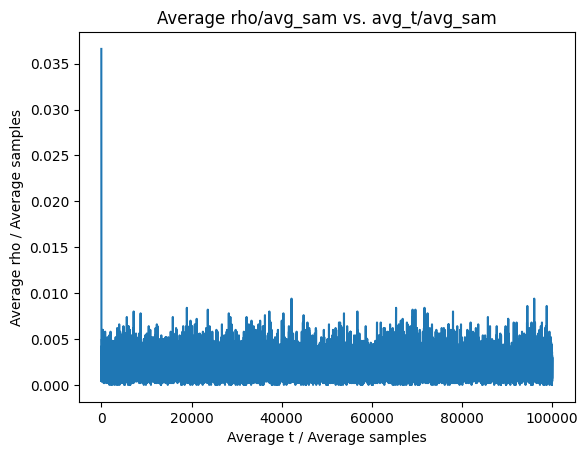

In [196]:
# Test configuration model
n= 1000
gamma = 4.0
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)
G = generate_configuration_model(degrees)

# Test SIS spreading
import sys
#output = sys.argv[1]
output = "/content/drive/My Drive/Networks/SIS_output_test1.txt"

N_sample = 5
mu = 1
lam = 0.3
max_time = 100000
frac_inf = 0.05

# Run dynamics
OGA_SIS_2(G, output, N_sample, mu, lam, max_time, frac_inf)


In [ ]:
def plot_avg_rho_vs_lambda(graph, output, N_sample, mu, max_time, frac_inf):
    lambdas = np.linspace(0, 1, num=100)  # Values of lambda from 0 to 1
    avg_rho_values = []

    for lam in lambdas:
        OGA_SIS(graph, output, N_sample, mu, lam, max_time, frac_inf)

        with open(output, 'rt') as file:
            lines = file.readlines()
            avg_rho = []
            for line in lines:
                if line.startswith('1.0'):
                    avg_rho.append(float(line.split()[1]))

        if avg_rho:
            avg_rho_values.append(np.mean(avg_rho))
        else:
            avg_rho_values.append(np.nan)

    plt.plot(lambdas, avg_rho_values)
    plt.xlabel('Lambda')
    plt.ylabel('Average Rho')
    plt.title('Average Rho vs. Lambda')
    plt.show()

In [ ]:
# Usage example
graph = G
# Add nodes and edges to the graph

#output = "/content/drive/My Drive/Networks/rho_lambda_output.txt"
N_sample = 10
mu = 1.0
max_time = 10000
frac_inf = 0.05

#plot_avg_rho_vs_lambda(graph, output, N_sample, mu, max_time, frac_inf)